In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
%pip install -Uq lightning

Note: you may need to restart the kernel to use updated packages.


In [5]:
import lightning as L
import torch
import torchvision
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets,transforms

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
!nvidia-smi


Tue Oct 17 16:28:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## As usual we will first create the Cifar10DataModule

In [8]:
class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path= './',batch_size=64, height_width=(32, 32), num_workers=2,train_transform=None, test_transform=None):
        super().__init__()
        self.data_path = data_path
        self.batch_size= batch_size
        self.height_width= height_width
        self.num_workers=num_workers
        self.train_transform=train_transform
        self.test_transform=test_transform
        
        
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)
        
        if self.train_transform is None:
            self.train_transform=transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor()
            ])
        
        if self.test_transform is None:
            self.test_transform=transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor()
            ])
            
        return
    
    
    
    def setup(self,stage=None):
        train =  datasets.CIFAR10(root=self.data_path, train=True, download=False, transform=self.train_transform)
        self.test = datasets.CIFAR10(root=self.data_path, train=False, download=False, transform=self.test_transform)
        
        
        self.train, self.valid = random_split(train,[45000,5000])
        
        
    def train_dataloader(self):
        train_loader= DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            drop_last=True)
        return train_loader
    
    def val_dataloader(self):
        val_loader= DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=True)
        return val_loader
    
    def test_dataloader(self):
        test_loader=DataLoader(
            dataset=self.test_loader,
            batch_size = self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=False,)
        return test_dataloader

## Next we will create the lightning model

In [63]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, weight_decay=0.01):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.weight_decay=weight_decay
        
        self.save_hyperparameters(ignore=['model'])
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass',num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        
        
        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels
    
    
    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        
        self.log('train_loss',loss)
        self.train_acc(true_labels, predicted_labels)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=False, on_step=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log('valid_loss',loss)
        self.val_acc(true_labels, predicted_labels)
        self.log('val_acc',self.val_acc)
        return loss
        
    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)
        return loss
    
    def configure_optimizers(self):
        optimizer=  torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

In [51]:
dm = Cifar10DataModule()
dm.prepare_data()
dm.setup()

Files already downloaded and verified


## See the image structure

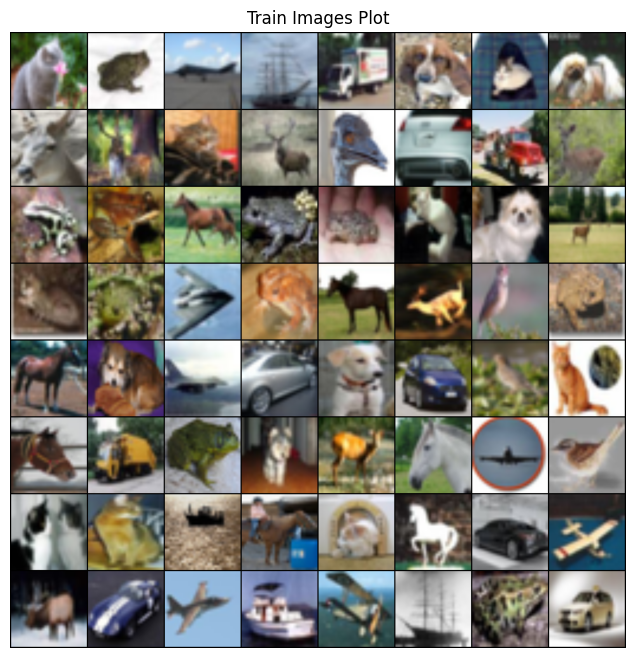

In [62]:
for images, labels in dm.train_dataloader():
    break
    
plt.figure(figsize=(8,8))
plt.title('Train Images Plot')
plt.axis('off')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

## Image Sampler

In [12]:
from torchvision import transforms
selfsupervised_transforms = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=128),
        transforms.RandomAutocontrast(),
        transforms.RandomInvert(),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor()
    ])



class AugmentedImages:
    def __init__(self, transformed):
        self.transforms = transformed
        self.base_transform = transforms.Compose([transforms.Resize(size=128),
                                                 transforms.ToTensor()])
    def __call__(self, x):
        return [self.transforms(x),self.transforms(x)]

In [13]:
dm = Cifar10DataModule(train_transform=AugmentedImages(selfsupervised_transforms),
                      test_transform=AugmentedImages(selfsupervised_transforms))

dm.prepare_data()
dm.setup()

Files already downloaded and verified


In [14]:
for images, labels, in dm.train_dataloader():
    break
    

paired_images = []
for i in range(64):
    paired_images.append(images[1][i])
    paired_images.append(images[0][i])

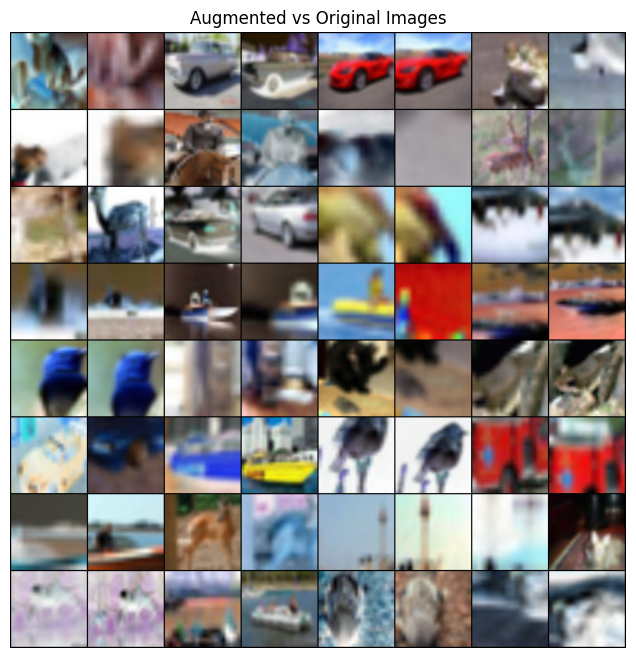

In [15]:
plt.figure(figsize=(8,8))
plt.title("Augmented vs Original Images")
plt.axis('off')
plt.imshow(np.transpose(torchvision.utils.make_grid(paired_images[:64],padding=2,normalize=True),(1,2,0)))
plt.show()

## List the models and load them

In [20]:
entrypoints = torch.hub.list('pytorch/vision')
for e in entrypoints:
    if 'resnet' in e:
        print(e)

deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [21]:
pytorch_model =  torch.hub.load('pytorch/vision', 'resnet34', weights=None)
#Not loading the pretrained weights

pytorch_model

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Next Use 2 fully connected layers

In [22]:
pytorch_model.fc = torch.nn.Sequential(
    torch.nn.Linear(512,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256))

## Info NCE(Non Contrastive Estimation) Loss[UPDATE]

In [23]:
np.linalg.norm?

Signature: np.linalg.norm(x, ord=None, axis=None, keepdims=False)
Docstring:
Matrix or vector norm.

This function is able to return one of eight different matrix norms,
or one of an infinite number of vector norms (described below), depending
on the value of the ``ord`` parameter.

Parameters
----------
x : array_like
    Input array.  If `axis` is None, `x` must be 1-D or 2-D, unless `ord`
    is None. If both `axis` and `ord` are None, the 2-norm of
    ``x.ravel`` will be returned.
ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
    Order of the norm (see table under ``Notes``). inf means numpy's
    `inf` object. The default is None.
axis : {None, int, 2-tuple of ints}, optional.
    If `axis` is an integer, it specifies the axis of `x` along which to
    compute the vector norms.  If `axis` is a 2-tuple, it specifies the
    axes that hold 2-D matrices, and the matrix norms of these matrices
    are computed.  If `axis` is None then either a vector norm (when `x`
    is 1

In [24]:
def info_nce_loss(feats, temperature, mode='train'):
    
    #calculate the cosine similarity
    cos_sim=F.cosine_similarity(feats[:,None, :], feats[None, :, :], dim=-1)
    
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # Find positive example batch_sizse//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
    
    # InfoNCE loss
    cos_sim = cos_sim/temperature
    
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()
    
    comb_sim = torch.cat(
        [cos_sim[pos_mask][:, None], cos_sim.masked_fill(pos_mask, -9e15)],  # First position positive example
        dim=-1,
    )
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    return nll, sim_argsort

### Updated Lightning Module

In [32]:
class LightningModelSimCLR(L.LightningModule):
    def __init__(self, model, learning_rate, temperature):
        super().__init__()

        self.learning_rate = learning_rate
        self.temperature = temperature
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):

        ### NEW ###
        images, true_labels = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="train", temperature=self.temperature)
        self.log("train_loss", loss)
        self.log("train_acc", (sim_argsort < 5).float().mean())
        
        return loss

    def validation_step(self, batch, batch_idx):

        ### NEW ###
        images, true_labels = batch
        images = torch.cat(images, dim=0)
        transformed_feats = self(images)

        loss, sim_argsort = info_nce_loss(transformed_feats, mode="val", temperature=self.temperature)
        self.log("val_loss", loss)
        self.log("val_acc", (sim_argsort == 0).float().mean())
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=0.01)
        return optimizer

In [33]:
L.seed_everything(329847)

L.seed_everything(123)

dm = Cifar10DataModule(batch_size=256, num_workers=4,
                       train_transform=AugmentedImages(selfsupervised_transforms),
                       test_transform=AugmentedImages(selfsupervised_transforms))

lightning_model = LightningModelSimCLR(model=pytorch_model, temperature=0.07, learning_rate=0.0005)

trainer = L.Trainer(
    max_epochs=5,
    accelerator="gpu",
    devices=1,
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
    
    
    
    
    
    
    
    
)

INFO: Seed set to 329847
INFO: Seed set to 123
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model=lightning_model, datamodule=dm)

Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 21.7 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.715    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [28]:
# finally save the model

torch.save(pytorch_model.state_dict(), "simclr-resnet34.pt")

# Finetune the ResNet we pretrained via self supervised learning

In [68]:
#load the model from the hub
pytorch_model = torch.hub.load('pytorch/vision', 'resnet34', weights=None)

pytorch_model.fc = torch.nn.Sequential(
    torch.nn.Linear(512,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,256))

pytorch_model.load_state_dict(torch.load('simclr-resnet34.pt'))
pytorch_model.fc = torch.nn.Linear(512,10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [69]:
L.seed_everything(123)
dm = Cifar10DataModule(height_width=(256, 256), batch_size=64, num_workers=4)
dm.prepare_data()
dm.setup()
lightning_model = LightningModel(model=pytorch_model ,learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=5,
    accelerator="gpu",
    devices=[0],
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

INFO: Seed set to 123


Files already downloaded and verified


INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [70]:
trainer.fit(lightning_model, datamodule=dm)

Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 21.3 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
